# Lecture 19: Mapper graphs in Python

In this notebook, we will run through basic examples of constructing mapper graphs using the [KeplerMapper](https://kepler-mapper.scikit-tda.org/en/latest/) from scikit-tda. If not already installed, uncomment and run the following cell. 


In [1]:
# pip install kmapper

In [2]:
# Imports 
import numpy as np
import sklearn
from sklearn import datasets
import matplotlib.pyplot as plt
import kmapper as km



## Credits 

This notebook was modified by Liz Munch from a previous version written by [Sourabh Palande](https://sourabhpalande.github.io/). 


## Mapper definition


We can think of mapper as a two-step soft clustering method, guided by a real-valued function (called a *lens* or a *filter function*) on the data. We use this *lens* to divide our data into smaller overlapping chunks (called cubes in `kmapper`) where a data point may fall into two or more chunks.
This part of the process is called creating a *cover*.

Let $\mathbb{X}$ be the point cloud and $f : \mathbb{X} \to \mathbb{R}$ be the *lens*. We divide the range of $f$ into overlapping intervals to create a cover $\mathcal{U} = \{U_{\alpha}\}$. 
This, in turn, allows us to compute $f^{-1}(\mathcal{U}) = \{f^{-1}(U_{\alpha})\}$, which is a cover of $\mathbb{X}$ (called a *pullback* cover).

Once we have a cover of $\mathbb{X}$, we apply our favorite clustering algorithm to each cover element separately. Then, we construct a graph where each node of the graph corresponds to a cluster from the clustering step. Lastly, if two clusters share the same data point(s), we connect the corresponding vertices of the graph by an edge.

The example we used in class is below. 

![](https://raw.githubusercontent.com/lizliz/CMSE890-TDA-Fall2025/refs/heads/main/JupyterFigures/MapperEx-web.png)

## Mapper of a toy dataset
Here, we will create and visualize a simple dataset with 700 points.

Download the data here: [MapperExampleCloud.txt](https://raw.githubusercontent.com/lizliz/CMSE890-TDA-Fall2025/refs/heads/main/JupyterFigures/MapperExampleCloud.txt)

In [3]:
data = np.loadtxt('MapperExampleCloud.txt')

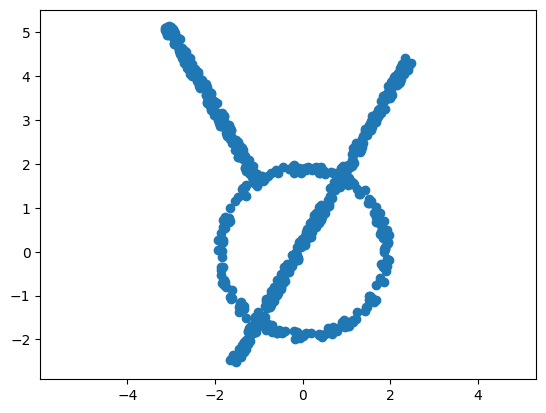

In [4]:
# Visualize sample data with a scatter plot
plt.scatter(data[:, 0], data[:, 1]);
plt.axis('equal');

### Initialize mapper object

Now we will create a mapper graph for this toy dataset. The first step is to initialize a KeplerMapper object.

In [5]:
# Initialize mapper object
# Set verbose = 0 to suppress output messages below
mapper = km.KeplerMapper(verbose=1)

KeplerMapper(verbose=1)


### Define lens / filter function

Next, we will need to define a *lens* function, which is any function $f:P \to \R$ that gives a real number for each input data point. In practice, you just need an array of $n$ numbers, one for each of the $n$ data points in $P$.  It is possible that your data comes with a lens function grounded in the domain from which it was obtained. However, if not, below are a few examples of lens functions that can be computed just given input data. 

#### Projection
First, we have the projection in some direction. In this case, we have the following code. 

In [6]:
theta = np.pi / 4  # 45 degree angle
w = (np.cos(theta), np.sin(theta))  # direction vector

# define a lens/filter function/projection by an inner product with w
lens_project = data @ np.array(w)  # projection lens

Here we will draw the points with the filter function shown as color. 

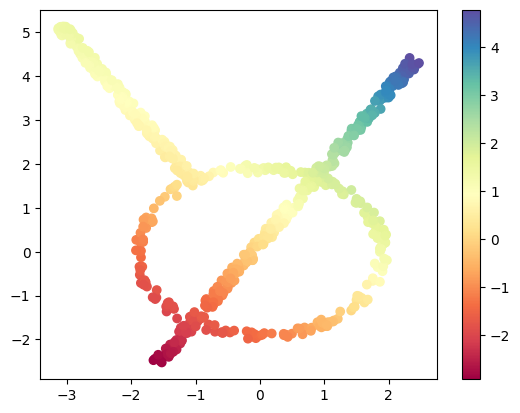

In [7]:
plt.scatter(data[:, 0], data[:, 1], c=lens_project, cmap='Spectral');
plt.colorbar();

**Try this:** Mess with the theta above, how does this change the lens function?

#### PCA as lens function 

As another option, we have the [PCA projection](https://en.wikipedia.org/wiki/Principal_component_analysis) as a lens function. 


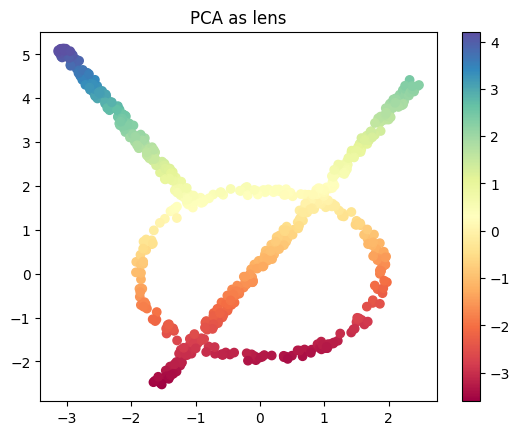

In [8]:
from sklearn.decomposition import PCA
lens_PCA = PCA(n_components=1).fit_transform(data)

plt.scatter(data[:, 0], data[:, 1], c=lens_PCA, cmap='Spectral');
plt.title('PCA as lens')
plt.colorbar();

#### Norm 
We can do the norm of each data point, which is simply the distance of the point from 0. 

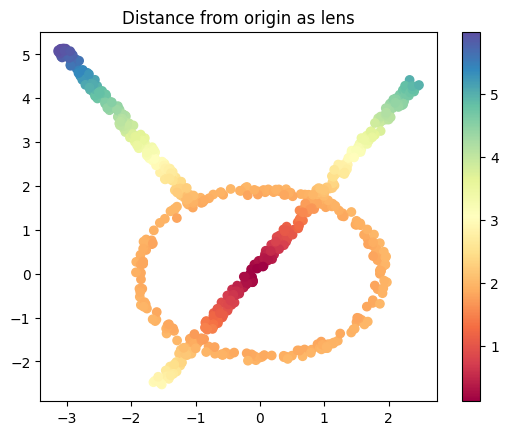

In [9]:
from numpy.linalg import norm
lens_norm = norm(data, axis=1, keepdims=True)

plt.scatter(data[:, 0], data[:, 1], c=lens_norm, cmap='Spectral');
plt.title('Distance from origin as lens')
plt.colorbar();

I'll make a modified version too which gives me the distance from the point $(-2,3)$

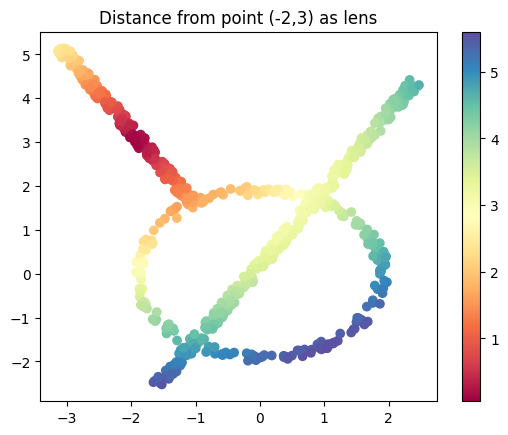

In [10]:
base_pt = (-2,3)
lens_norm2 = norm(data-base_pt, axis=1, keepdims=True)

plt.scatter(data[:, 0], data[:, 1], c=lens_norm2, cmap='Spectral');
plt.title('Distance from point (-2,3) as lens')
plt.colorbar();

#### Eccentricity 

We can define the eccentricity of the points like we did in class. 

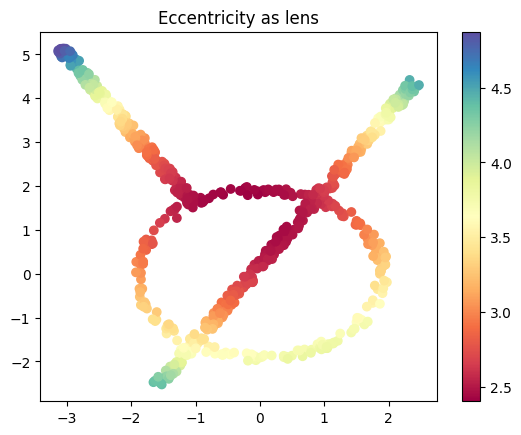

In [11]:
from scipy.spatial.distance import cdist

# Compute the pairwise distance matrix
D = cdist(data, data)

# Eccentricity (p=1 from the equation in class) is the mean distance to all other points
eccentricity = D.mean(axis=1)


plt.scatter(data[:, 0], data[:, 1], c=eccentricity, cmap='Spectral')
plt.title('Eccentricity as lens')
plt.colorbar();

### Define cover

Next step is to define the *cover*. To do so, we will split the range of the *lens* function into specified number of intervals (`n_cubes`). Where the size of overlap between consecutive intervals is given as a percentage of interval length (`perc_overlap`). For example, if the range of the *lens* is (0-100) and we specify `n_cube = 2` and `perc_overlap = 0.1`, respectively, then the two intervals we get are `[0, 60)` and `[50-100)`.<br>


In [12]:
cover = km.Cover(n_cubes=10, perc_overlap=0.3)


With Keppler Mapper
Once the cover is defined, mapper will split the data so that all the data points that map to the same interval are put into the same chunk. Since the intervals overlap, there would be points that map to more than one interval and hence, belong to more than one chunk.

In [13]:
# Initialize cover
# Note that we want perc_overlap <= .5
cover = km.Cover(n_cubes=10, perc_overlap=0.3)

### Specify clustering algorithm

Next, we want to apply clustering to each chunk. So we specify our favorite clustering algorithm. The default algorithm used by mapper is [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN), but we can use any clustering algorithm or indeed write our own if needed. However, one poor choice is kNN since you need to specify the number of clusters in advance (but our whole idea here is that we want the clustering algorithm to figure that out for us). More options for clustering algorithms can be found in [scikit-learn's cluster module](https://scikit-learn.org/stable/modules/clustering.html) is used.

In [14]:
# Initialize clustering algorithm
from sklearn.cluster import DBSCAN
clust_metric = 'euclidean'
clusterer = DBSCAN(metric=clust_metric)

### Construct mapper graph

Now, we have all the ingredients to construct the mapper graph. We use the `.map` method of the KepplerMapper object we made a while ago to construct the graph.

In [15]:
# Create mapper graph: a dictionary with nodes, edges and meta-information
graph = mapper.map(lens=lens_project, X=data, cover=cover, clusterer=clusterer)

Mapping on data shaped (700, 2) using lens shaped (700,)

Creating 10 hypercubes.

Created 18 edges and 17 nodes in 0:00:00.009559.


### Visualize the mapper graph

Lastly, we will use the `visualize` method of KepplerMapper object to create a visualization and save it in an html file. There are other ways to create visualizations, we can export the graph to a standard graph package like networkx or igraph. But the html version is very convenient. We will create the html file and then load it into a frame below. Click on the link that shows up to see your output. 

In [16]:
# # Visualize the created graph
# from helper_functions import colorscale_from_matplotlib_cmap
# cscale = colorscale_from_matplotlib_cmap(plt.get_cmap('coolwarm'))

_ = mapper.visualize(graph,
                     path_html="./example_mapper.html",
                     title="make_circles(n_samples=5000, noise=0.03, factor=0.3)",
                     color_values=lens_project,
                     color_function_name='labels'
                    )

Wrote visualization to: ./example_mapper.html



In the visualization, you can zoom in and out on parts of the graph.<br>
Click on the `+` sign in from of *cluster details* to open a panel on the left. When you hover over a node in the graph, this panel will display information about the cluster.<br>
Click on the `+` sign in from of *mapper summary* to open a panel on the right. This panel shows the parameters used to construct the mapper graph.

## Your turn

Now you have all the tools to build mapper graphs! 

### Test changing parameters on this data set
Do the following. 

- For each of the lens functions above, recompute the mapper graph. What changes for the different options? 
- Pick on lens function you like (I'm always a fan of the projection for interpretability). Try using a different number of cover intervals, from 2 to 30. How does this affect the graph? 
- Now try fixing the lens function and number of cover intervals, but change the percentage overlap, from 10 to 50%. What changes here? 

In [17]:
# your code here

### Different data sets 

Load the circle data set from sklearn below. 

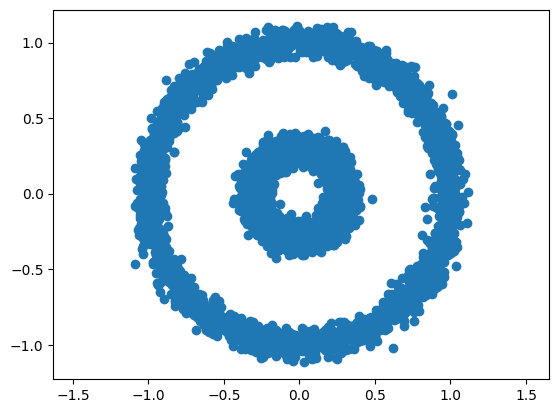

In [18]:
# Load sample data
data, _ = datasets.make_circles(n_samples=5000, noise=0.05, factor=0.3)

plt.scatter(data[:, 0], data[:, 1])
plt.axis('equal');

Do this: 

- How do the different lens functions look on this data set? 
- Which do you expect to have a mapper graph that is (approximately) two circles? Which do you expect **not** to look like two circles? 
- Test your guess above by computing the mapper graphs of these lens functions. 

In [19]:
# Your code here